# Imports & Display Settings

In [106]:
# Core libraries
import numpy as np
import polars as pl                                  
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
from datetime import datetime

# Scikit-learn components
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, make_scorer, classification_report)

# XGBoost model
from xgboost import XGBClassifier, plot_importance

# Plot style (optional)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Retrieve Data

In [48]:
# Define the symbol for WTI crude oil futures on Yahoo Finance
symbol = 'CL=F'  # 'CL=F' stands for Crude Oil WTI Futures

# Define the date range: from Jan 1, 2000 to today
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # automatically gets today's date

# Define the data interval (daily frequency)
interval = '1d'  # Options: '1d', '1wk', '1mo'

# Retrieve historical data using yfinance
ticker = yf.Ticker(symbol)
historical_data = ticker.history(start=start_date, end=end_date, interval=interval)

# Display the first few rows
print(f"Downloaded data from {start_date} to {end_date}")
print("Data shape:", historical_data.shape)
display(historical_data.head())

csv_path = "wti_historical_data.csv"
historical_data.to_csv(csv_path)
print(f"Historical data saved to: {csv_path}")

Downloaded data from 2000-01-01 to 2025-07-12
Data shape: (6247, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-23 00:00:00-04:00,31.950001,32.799999,31.950001,32.049999,79385,0.0,0.0
2000-08-24 00:00:00-04:00,31.900000,32.240002,31.400000,31.629999,72978,0.0,0.0
2000-08-25 00:00:00-04:00,31.700001,32.099998,31.320000,32.049999,44601,0.0,0.0
2000-08-28 00:00:00-04:00,32.040001,32.919998,31.860001,32.869999,46770,0.0,0.0
2000-08-29 00:00:00-04:00,32.820000,33.029999,32.560001,32.720001,49131,0.0,0.0


Historical data saved to: wti_historical_data.csv


# Feature Engineering

In [51]:

# Load the historical data from the CSV
wti = pl.read_csv("wti_historical_data.csv", try_parse_dates=True)

# Show the first few rows and column names
print(f"Shape: {wti.shape}")
wti.head()

Shape: (6247, 8)


Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
"datetime[μs, UTC]",f64,f64,f64,f64,i64,f64,f64
2000-08-23 04:00:00 UTC,31.950001,32.799999,31.950001,32.049999,79385,0.0,0.0
2000-08-24 04:00:00 UTC,31.9,32.240002,31.4,31.629999,72978,0.0,0.0
2000-08-25 04:00:00 UTC,31.700001,32.099998,31.32,32.049999,44601,0.0,0.0
2000-08-28 04:00:00 UTC,32.040001,32.919998,31.860001,32.869999,46770,0.0,0.0
2000-08-29 04:00:00 UTC,32.82,33.029999,32.560001,32.720001,49131,0.0,0.0


In [53]:
# Rename columns to match the professor’s jump-start code expectations (if needed)
# Convert column names to title case if Yahoo changed format
wti = wti.rename({
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Close": "Close",
    "Volume": "Volume"
})

# Create lag features for Close and Volume
for lag in range(1, 4):
    wti = wti.with_columns([
        pl.col("Close").shift(lag).alias(f"CloseLag{lag}"),
        pl.col("Volume").shift(lag).alias(f"VolumeLag{lag}"),
        (pl.col("High") - pl.col("Low")).shift(lag).alias(f"HMLLag{lag}"),
        (pl.col("Open") - pl.col("Close")).shift(lag).alias(f"OMCLag{lag}")
    ])

# Exponential moving averages (on lagged close to avoid leakage)
wti = wti.with_columns([
    pl.col("CloseLag1").ewm_mean(half_life=1).alias("CloseEMA2"),
    pl.col("CloseLag1").ewm_mean(half_life=2).alias("CloseEMA4"),
    pl.col("CloseLag1").ewm_mean(half_life=4).alias("CloseEMA8")
])

# Log return and binary target
wti = wti.with_columns([
    (pl.col("Close") / pl.col("CloseLag1")).log().alias("LogReturn"),
    pl.when(pl.col("Close") > pl.col("CloseLag1")).then(1).otherwise(0).alias("Target")
])

# Descriptive Statistics for Key Price Features

In [60]:
# Select only columns that actually exist in your wti DataFrame
price_cols = [
    "Open", "High", "Low", "Close",
    "CloseLag1", "CloseLag2", "CloseLag3",
    "HMLLag1", "HMLLag2", "HMLLag3",
    "OMCLag1", "OMCLag2", "OMCLag3",
    "Volume", "VolumeLag1", "VolumeLag2", "VolumeLag3",
    "CloseEMA2", "CloseEMA4", "CloseEMA8",
    "LogReturn"
]

# Convert to pandas and show descriptive statistics
wti_stats = wti.select(price_cols).to_pandas().describe().T.round(4)
print("Descriptive Statistics for Selected Price Features:")
display(wti_stats)

Descriptive Statistics for Selected Price Features:


,count,mean,std,min,25%,50%,75%,max
Open,6247.0,64.7308,24.8071,-14.0000,45.9750,64.0300,82.4200,1.451900e+02
High,6247.0,65.7298,25.0709,13.6900,46.9150,64.9600,83.4050,1.472700e+02
Low,6247.0,63.6595,24.5134,-40.3200,45.1050,63.1000,81.1850,1.432200e+02
Close,6247.0,64.7209,24.8137,-37.6300,45.9900,63.9700,82.4400,1.452900e+02
CloseLag1,6246.0,64.7203,24.8156,-37.6300,45.9750,63.9700,82.4400,1.452900e+02
CloseLag2,6245.0,64.7200,24.8176,-37.6300,45.9600,63.9700,82.4400,1.452900e+02
CloseLag3,6244.0,64.7194,24.8195,-37.6300,45.9575,63.9600,82.4450,1.452900e+02
HMLLag1,6246.0,2.0703,1.5958,0.0200,1.2000,1.7300,2.5100,5.817000e+01
HMLLag2,6245.0,2.0703,1.5959,0.0200,1.2000,1.7300,2.5100,5.817000e+01
HMLLag3,6244.0,2.0704,1.5960,0.0200,1.2000,1.7300,2.5100,5.817000e+01


# Distribution of Log Returns

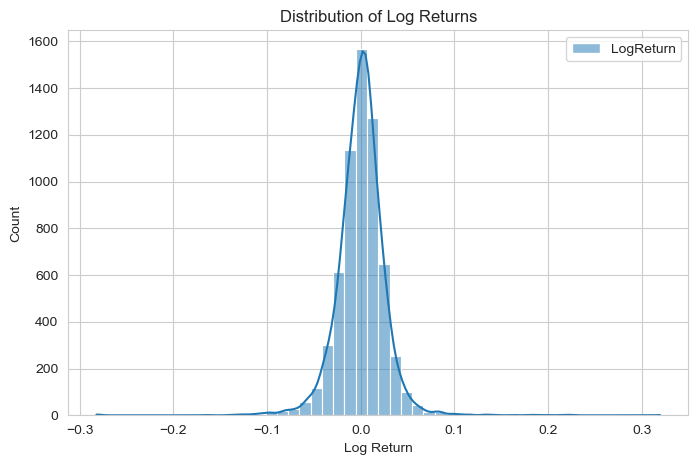

In [64]:
# Plot histogram of log returns
sns.histplot(wti.select("LogReturn").to_pandas(), bins=50, kde=True)
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.show()

# Drop Missing Values (caused by lagging and EMAs)

In [24]:
# Drop rows with any null values caused by shifting or ewm
wti = wti.drop_nulls()

# Print schema to confirm structure
print(wti.schema)

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'Dividends': Float64, 'Stock Splits': Float64, 'CloseLag1': Float64, 'VolumeLag1': Int64, 'HMLLag1': Float64, 'OMCLag1': Float64, 'CloseLag2': Float64, 'VolumeLag2': Int64, 'HMLLag2': Float64, 'OMCLag2': Float64, 'CloseLag3': Float64, 'VolumeLag3': Int64, 'HMLLag3': Float64, 'OMCLag3': Float64, 'CloseEMA2': Float64, 'CloseEMA4': Float64, 'CloseEMA8': Float64, 'LogReturn': Float64, 'Target': Int32})


#  Prepare Feature Matrix X and Target y

In [27]:
# Drop current-day raw values to avoid information leakage
columns_to_drop = [
    "Date", "Open", "High", "Low", "Close", "Volume", "LogReturn", "Target"
]

X = wti.drop(columns_to_drop, strict=False)
y = wti["Target"].to_numpy()
X_np = X.to_numpy()

print("Feature matrix shape:", X_np.shape)

Feature matrix shape: (6244, 17)


# Standardize All Features

In [71]:

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform X
X_scaled = scaler.fit_transform(X_np)

print("Feature matrix standardized.")
print("Shape:", X_scaled.shape)

Feature matrix standardized.
Shape: (6244, 17)


# Feature Selection

Top 10 important features (XGBoost):
1. CloseEMA4 (0.0816)
2. CloseEMA8 (0.0747)
3. CloseLag2 (0.0725)
4. CloseLag3 (0.0696)
5. OMCLag2 (0.0670)
6. HMLLag3 (0.0663)
7. HMLLag2 (0.0660)
8. CloseEMA2 (0.0659)
9. OMCLag1 (0.0651)
10. VolumeLag3 (0.0648)


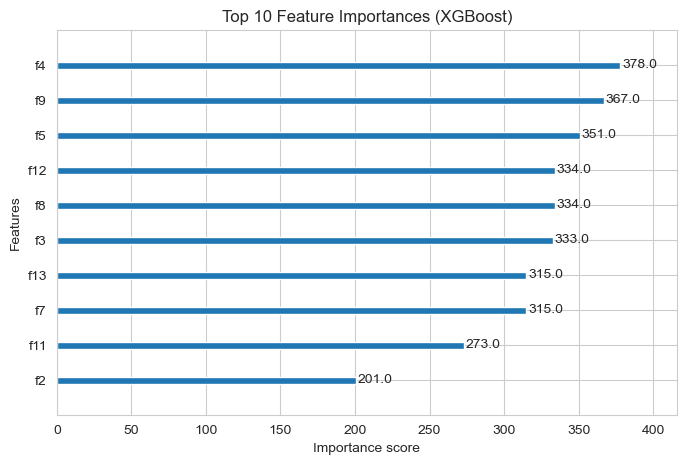

In [85]:
from xgboost import XGBClassifier, plot_importance

xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_scaled, y)


importances = xgb.feature_importances_
sorted_indices = importances.argsort()[::-1]
sorted_features = [X.columns[i] for i in sorted_indices]

print("Top 10 important features (XGBoost):")
for i in range(10):
    print(f"{i+1}. {sorted_features[i]} ({importances[sorted_indices[i]]:.4f})")


plot_importance(xgb, max_num_features=10)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()

# Time Series Cross-Validation + Model Training

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 Best Hyperparameters Found:
           subsample: 0.6
        n_estimators: 400
    min_child_weight: 1
           max_depth: 3
       learning_rate: 0.1
               gamma: 0.0
    colsample_bytree: 1.0

Best CV ROC-AUC: 0.5175


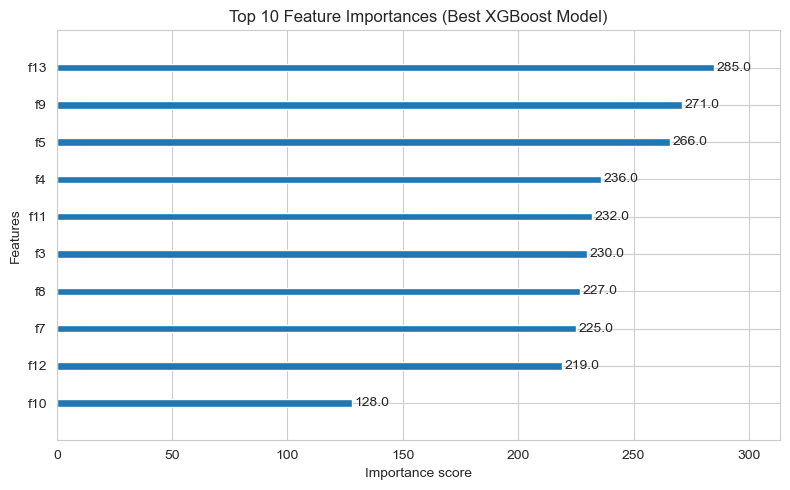

In [97]:
# 1. Define cross-validation method
tscv = TimeSeriesSplit(n_splits=5)

# 2. Define the base XGBoost classifier (no deprecated params)
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 3. Define hyperparameter grid
param_dist = {
    "n_estimators":     [200, 400, 600],
    "learning_rate":    [0.01, 0.05, 0.1],
    "max_depth":        [3, 4, 5, 6],
    "subsample":        [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma":            [0.0, 0.1, 0.2],
}

# 4. Define scoring function (no deprecation warning)
roc_auc = make_scorer(roc_auc_score, response_method='predict_proba')

# 5. Set up randomized search
xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,                   # increase for broader search
    scoring=roc_auc,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 6. Fit to standardized data (use X_scaled or your selected X)
xgb_search.fit(X_scaled, y)

# 7. Output best params and performance
print("\n Best Hyperparameters Found:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k:>18}: {v}")
print(f"\nBest CV ROC-AUC: {xgb_search.best_score_:.4f}")

# 8. Plot top features of final model
best_model = xgb_search.best_estimator_

plot_importance(best_model, max_num_features=10)
plt.title("Top 10 Feature Importances (Best XGBoost Model)")
plt.tight_layout()
plt.show()

# Evaluate best_model

Accuracy: 0.7771
ROC-AUC: 0.8608


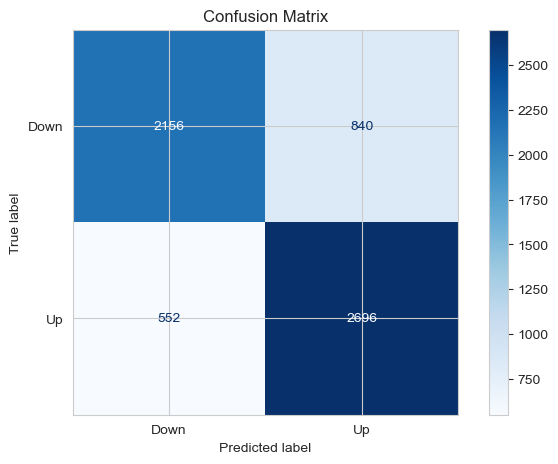

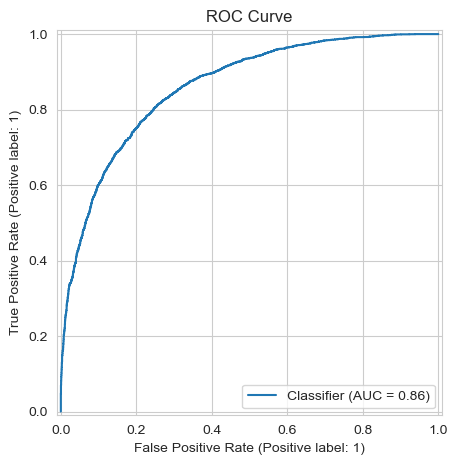

In [100]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

# Step 1: Generate model predictions (probabilities and labels)
y_pred_proba = best_model.predict_proba(X_scaled)[:, 1]  # Probability of class 1
y_pred_label = best_model.predict(X_scaled)              # Hard class prediction

# Step 2: Accuracy Score
acc = accuracy_score(y, y_pred_label)
print(f"Accuracy: {acc:.4f}")

# Step 3: ROC-AUC Score
auc = roc_auc_score(y, y_pred_proba)
print(f"ROC-AUC: {auc:.4f}")

# Step 4: Confusion Matrix
cm = confusion_matrix(y, y_pred_label, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Step 5: ROC Curve
RocCurveDisplay.from_predictions(y, y_pred_proba)
plt.title("ROC Curve")
plt.grid(True)
plt.show()

# Reference
* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).